# Frank-Wolfe Algorithm

*Mar, 2017 by K.Wu*

In this report, network are presented as a CSV file:

- [**/data/Frank-Wolfe-algo-data.csv**](https://github.com/wklchris/Reports/blob/master/data/Frank-Wolfe-algo-data.csv): All links of the network.

First, here are the packages needed in this report. Install: 

- Python 3
- numpy package
- pandas package

to continue.

In [1]:
import os
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation

## Introduction

In this report, we have a network like below:

<img src="https://raw.githubusercontent.com/wklchris/Reports/master/pics/FrankWolfe-network.png" alt="Network Picture" style="width: 500px;"/>

The free flow travel time $t_a$ and capacities $c_a$ for each type of link are:

- Black links: $t_a = 10, c_a = 50$
- Red links: $t_a = 30, c_a = 200$
- Yellow links: $t_a = 15, c_a = 200$
- Cyan links: $t_a = 0, c_a = 2000$

We also have the O-D table of this network, shown as below:

In [2]:
ODarr = pd.DataFrame([[100, 200, 300, 50],
                      [100, 200, 200, 100],
                      [300, 50, 100, 100],
                      [200, 500, 50, 200]])

# Rename columns & rows
ODarr.columns = list(range(201, 205))
ODarr.index = list(range(101, 105))

ODarr

,201,202,203,204
101,100,200,300,50
102,100,200,200,100
103,300,50,100,100
104,200,500,50,200


## Network Representation



In [3]:
linkarr = pd.read_csv(r"{}/data/Frank-Wolfe-algo-data.csv".format(os.getcwd()))
linkarr.head()

,start,end,type
0,1,2,black
1,2,3,black
2,3,4,black
3,14,15,black
4,15,16,black


We can modify the link array according to the type:

In [4]:
linkarr["fftime"] = 0
linkarr["cap"] = 0

# Set the FreeFlowTraveltime and Capacity of each link
linkarr.loc[linkarr.type == "black", "fftime"] = 10
linkarr.loc[linkarr.type == "black", "cap"] = 50
linkarr.loc[linkarr.type == "yellow", "fftime"] = 15
linkarr.loc[linkarr.type == "yellow", "cap"] = 200
linkarr.loc[linkarr.type == "red", "fftime"] = 30
linkarr.loc[linkarr.type == "red", "cap"] = 200
linkarr.loc[linkarr.type == "cyan", "fftime"] = 0
linkarr.loc[linkarr.type == "cyan", "cap"] = 2000

linkarr.head(3)

,start,end,type,fftime,cap
0,1,2,black,10,50
1,2,3,black,10,50
2,3,4,black,10,50


## Application Scenarios

As for the costs, we use BPR function to compute the cost on each link. Cost on link $a$, called $t_a$, is a function of $x_a$:

$$ t_a(x_a) = t_a^0 \left[1 + \alpha\left(\frac{x_a}{c_a'}\right)^\beta\right] $$

where $\alpha = 0.15, \beta = 4, c_a' = 0.9c_a$. And we can define it as a function:

In [5]:
def bpr(xa, fft, ca, alpha=0.15, beta=4, ca_factor=0.9):
    """
    Compute the cost when the flow is 'xa' with BPR function.
    """
    return np.multiply(fft, 1 + alpha * (np.divide(xa, ca_factor * ca) ** beta))

As aforementioned, $\beta = 4$. So we need a function to search the numerical solution for quadratic equation:

In [6]:
def solvex4eq(q, theta=0.001, a=0, b=1):
    """
    Bi-section method to solve quartic equation.
    """
    y = lambda x: q[0] + q[1] * x + q[2] * x ** 2 + q[3] * x ** 3 + q[4] * x ** 4
    fa = y(a)
    fb = y(b)
    
    if fa * fb > 0:
        return list(map(y, np.linspace(a, b, 20)))
    elif (fa == 0):
        return a
    elif (fb == 0):
        return b
    
    while (b - a > theta):
        c = (b + a) / 2
        fc = y(c)
        if (fc == 0):
            return c
        elif (fc * fa < 0):
            b = c
        elif (fc * fb < 0):
            a = c
    
    return c

# Example: (x + 1)^3 * (x - 0.2) = 0
solvex4eq([-0.2, 0.4, 2.4, 2.8, 1])

0.2001953125

As for the shortest path finding, we use the function defined in the [Label-correcting-algo.ipynb](https://github.com/wklchris/Reports/blob/master/Label-correcting-algo.ipynb):

In [7]:
def label_correcting_algo(dt, ori_node, des_node, do_return=False):
    """
    Find the shortest path from Origin to Destination under a constant-link-costs network.
    
    Args:
        dt: Network representation. At least 3 columns:
              "start": start nodes of links
              "end": end nodes of links
              "cost": constant costs of links
        ori_node: Origin node.
        des_node: Destination node.
        do_return: Boolean. 
            If True, Return a dataframe as described below.
            If False, Return the list of nodes on the shortest path.
        
    Returns:
        If do_return == True, return a dataframe of two columns:
            "Front-Node": The node visited before current node on the shortest path.
            "Distance": Total distance from origin to current node.
        If do_return == False, return a list.
    """
    # Convert all labels to string
    ori = str(ori_node)
    des = str(des_node)
    dt[["start", "end"]] = dt[["start", "end"]].astype(str) 
    
    # Initialization
    nodes = set(dt.loc[:,"start"].unique()) | set(dt.loc[:,"end"].unique())
    dist = {}.fromkeys(nodes, np.inf)
    dist[ori] = 0
    points = {}.fromkeys(nodes, ori)
    iter_set = {ori}
    
    # Main Algo
    while iter_set:
        i = iter_set.pop()  # Randomly pop out a node i
        A_i = dt[dt.start == i]
        for row in A_i.index: 
            j = A_i.loc[:, "end"][row]
            c_ij = A_i.loc[:, "cost"][row]
            if dist[j] > dist[i] + c_ij:
                dist[j] = dist[i] + c_ij
                points[j] = i
                iter_set = iter_set | set([j])  # Union
    
    # Print & Return the Answer
    x = pd.concat([pd.Series(points), pd.Series(dist)], axis=1)
    x.columns = ["Front-node", "Costs"]

    current_node = des
    front_node = ""
    sp = [des]
    while front_node != ori:
        front_node = str(x.loc[current_node, "Front-node"])
        # sp = "{} -> {}".format(front_node, sp)
        sp.insert(0, front_node)
        current_node = front_node
    
    # sp.append(x.loc[des, "Costs"])
    # sp = "From node {} to node {}, total cost: {}\n{}\n".format(ori, des, x.loc[des, "Costs"], sp)
    if do_return:
        print(sp)
        return x
    else:
        return sp

First, we use free flow travel time to find the initial shortest path. So the cost under this situation equals free flow travel time:

In [8]:
bprlinkarr = linkarr.copy()
bprlinkarr["cost"] = bprlinkarr.fftime
del(bprlinkarr["type"])

bprlinkarr.head()

,start,end,fftime,cap,cost
0,1,2,10,50,10
1,2,3,10,50,10
2,3,4,10,50,10
3,14,15,10,50,10
4,15,16,10,50,10


Define a function to implement the algorithm:

1. Initialization
2. Do AON assignment for every O-D pair based on current link costs
3. Load those flow on the network, and re-compute costs on each link
4. Do the line search and find the numerical solution of "k"
5. Update the flow on each link by $x_a + k\times direction$
6. Check the err. If err > thre, go to step 2; otherwise, next.
7. Return a dataframe with assignments in each iteration.

For user equilibrium (UE), the object function in iteration $i$ is:

$$ z_1(k) = \sum_a \int_0^{x_a^{(i-1)} + k\times d_a^{(i)}} t_a(x)\,\mathrm{d} x $$

It should have a minimal between [0, 1]. Then:

$$\exists k^*, \quad\textrm{s.t. } \left.\frac{\\,\mathrm{d} z_1}{\,\mathrm{d} k}\right|_{k=k^*} = 0$$

Therefore, we have (omit iteration label $i$):

$$
\sum_a t_a^0 \left[1 + \alpha\left(\frac{x_a + k^*d_a}{c_a'}\right)^\beta\right]\cdot d_a = 0
$$

Simplify the coeffecients and put them into the function defined below. Similarly, we can get the coeffecients under system optimal (SO) scenario, which is also included in the function.

In [9]:
def bpr_coef(df, d, xa_idx_str, eq_type="ue", alpha=0.15):
    p4 = alpha * sum(np.multiply(df.fftime, np.divide(d ** 5, (0.9 * df.cap) ** 4)))
    p3 = alpha * 4 * sum(np.multiply(df.fftime, np.divide(np.multiply(df[xa_idx_str], d ** 4), (0.9 * df.cap) ** 4)))
    p2 = alpha * 6 * sum(np.multiply(df.fftime, np.divide(np.multiply(df[xa_idx_str] ** 2, d ** 3), (0.9 * df.cap) ** 4)))
    p1 = alpha * 4 * sum(np.multiply(df.fftime, np.divide(np.multiply(df[xa_idx_str] ** 3, d ** 2), (0.9 * df.cap) ** 4)))
    p0 = sum(alpha * np.multiply(df.fftime, np.divide(np.multiply(d, df[xa_idx_str] ** 4), (0.9 * df.cap) ** 4)) + np.multiply(df.fftime, d))
    
    if (eq_type != "ue"):
        p4 *= 5
        p3 *= 5
        p2 *= 5
        p1 *= 5
        p0 = 5 * p0 - 4 * sum(np.multiply(df.fftime, d))
    
    return [p0, p1, p2, p3, p4]

Then we define the main function:

In [10]:
def frank_wolfe(dt, OD_arr, eq="ue", thre=1, max_iters=50, alpha=0.15):
    ori_lst = OD_arr.index
    des_lst = OD_arr.columns
    err = thre + 1
    iters = 0
    x = dt.copy()  # Deepcopy
    x.cost = x.fftime  # Double-check for s.p. algo
    
    while (err > thre):
        new_col = "xa{}".format(iters)
        x[new_col] = 0
        x["cost{}".format(iters)] = 0
        
        # AON assignment
        sp_arr = {}
        for i in range(len(ori_lst)):
            ori = ori_lst[i]
            for j in range(len(des_lst)):
                des = des_lst[j]
                demand = OD_arr.at[ori, des]
                splst = label_correcting_algo(x, ori, des)
                # Shortest path for each OD pair
                # sp_arr["{}-{}".format(ori, des)] = splst[:]  # Deepcopy
                while len(splst) > 1:
                    current_node = splst.pop()
                    front_node = splst[-1]
                    x.loc[(x.start == front_node) & (x.end == current_node), new_col] += demand
        
        # Line search
        if (iters > 1):
            direction = x[new_col] - x[old_col]
            
            # Compute the coefficients of the equation of k. 
            # eq = "ue" / "so"
            coef_lst = bpr_coef(x, direction, old_col, eq_type=eq)
            
            # Numerical Solution
            k = solvex4eq(coef_lst)
            if (type(k) == type([])):
                print("Solving error. Iteration: {}".format(iters))
                return k
            x[new_col] = x[old_col] + k * (x.loc[:, new_col] - x[old_col])
            
            # Compute the error
            err = np.sqrt(sum((x[new_col] - x[old_col]) ** 2)) / sum(x[old_col])

        # Update the costs
        # xa-[iters] is computed based on cost-[iters] (so cost1 == fftime)
        x["cost{}".format(iters)] = x.cost
        x.cost = bpr(x[new_col], x.fftime, x.cap)
        
        # Non-convergence Break
        if (iters > max_iters):
            print("Force stop at Iteration {}. Final error: {:.4f}".format(max_iters, err))
            return x
        
        # Move forward
        old_col = "xa{}".format(iters)
        iters += 1
    
    # End of while loop
    print("Total iteration: {} for {}. Error: {:.4f}.".format(iters, eq, err))
    return x

### Q1

*Find the user equilibrium (UE) flow pattern, and compute the total travel time experienced by all users (this is not to be confused with the sum of the integral of travel times). Plot the convergence curves (total network link flow vs iteration number, total network travel time vs iteration number) and discuss your results.*

-----

Here's the solution for Q1:

In [11]:
q1 = frank_wolfe(bprlinkarr, ODarr, thre=0.001)
q1

Total iteration: 48 for ue. Error: 0.0009.


,start,end,fftime,cap,cost,xa0,cost0,xa1,cost1,xa2,...,xa43,cost43,xa44,cost44,xa45,cost45,xa46,cost46,xa47,cost47
0,1,2,10,50,959.584281,550,10,0,33482.793781,240.576172,...,227.387043,897.542952,224.095682,987.921655,227.415425,932.518660,224.123537,988.409989,225.721578,932.977420
1,2,3,10,50,793.510047,700,10,0,87838.074989,407.128906,...,217.205662,754.933480,213.175479,824.190012,215.464797,765.422978,211.466915,798.399795,215.129933,741.494261
2,3,4,10,50,924.246388,550,10,0,33482.793781,240.576172,...,222.344523,869.859214,219.146724,904.019406,222.596957,853.686568,219.394474,908.086349,223.591615,857.508269
3,14,15,10,50,788.540042,450,10,0,15010.000000,203.564453,...,212.819480,728.256382,209.798415,760.389436,216.131855,718.679737,213.049331,808.208466,214.787962,763.636458
4,15,16,10,50,476.489543,600,10,0,47417.407407,370.117188,...,188.939375,457.926160,185.433664,476.155814,191.091175,442.509375,187.545538,497.757244,188.973183,462.551646
5,16,9,10,50,1078.004478,600,10,0,47417.407407,259.082031,...,232.634424,1030.256191,230.173434,1081.364181,234.651283,1036.743565,230.297401,1119.003542,232.451829,1038.957302
6,8,1,15,200,59.811306,0,15,1200,15.000000,755.859375,...,381.087782,61.673747,383.294161,60.205638,378.461210,61.261671,382.571793,58.972179,380.253987,60.913910
7,1,9,15,200,912.980014,100,15,1850,15.214335,1165.283203,...,803.700739,947.724248,809.198479,909.272690,801.045785,933.994113,808.448256,897.514512,804.532409,930.590781
8,9,10,15,200,42.639542,0,15,1150,15.000000,724.365234,...,336.335163,44.326723,339.371913,42.427208,335.697067,43.431258,338.745657,42.219659,336.984238,43.221977
9,10,9,15,200,15.000000,0,15,0,15.000000,0.000000,...,0.000000,15.000000,0.000000,15.000000,0.000000,15.000000,0.000000,15.000000,0.000000,15.000000


Draw a animation graph to show the result:

In [12]:
links = np.arange(len(q1)) + 1
iters = (q1.shape[1] - 5) // 2
iterlst = list(map(lambda x: "xa{}".format(x), np.arange(iters)))
y = list(np.array(q1[iterlst].T))

# Draw animation graphs
fig, ax = plt.subplots()
fig.set_tight_layout(True)

ax.plot(links, q1.iloc[:, -2], 'r-', linewidth=2)
plt.hold(True)
line, = ax.plot(links, links - 5, 'k-')
ax.plot([28, 28], [0, 2000], 'k--')
ax.text(30, 1500, "Dummy links")
ax.axis(ymin=0)
ax.set_xlabel("# of links")
ax.set_ylabel("Flow")
plt.hold(False)
#line, = ax.plot(links, links - 5, 'r-', linewidth=2)

def update(i):
    global q1, iters
    line.set_ydata(q1.loc[:, "xa{}".format(i)])
    ax.set_title("Iteration {} (Total {})".format(i, iters))
    return line, ax

anim = FuncAnimation(fig, update, np.arange(iters), interval=0.3*1000)

In [13]:
# Save the animation
anim.save(r'{}/pics/FrankWolfe-q1-linkflow.gif'.format(os.getcwd()), dpi=100, writer='imagemagick')

Here's the animation graph:

<img src="https://raw.githubusercontent.com/wklchris/Reports/master/pics/FrankWolfe-q1-linkflow.gif" alt="Network Picture" style="width: 700px;"/>

Of course, we can draw figures of total flow/travel time vs iteration:

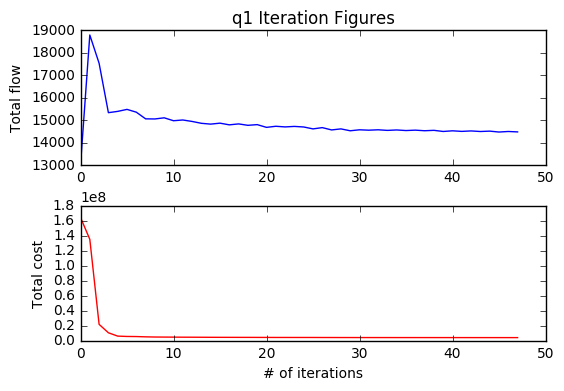

In [14]:
q1_iters = (q1.shape[1] - 5) // 2
q1_iterlst = list(map(lambda x: "xa{}".format(x), np.arange(q1_iters)))
q1_costlst = q1[q1_iterlst].apply(bpr, fft=q1.fftime, ca=q1.cap)

q1_xa_total = q1[q1_iterlst].apply(sum)
q1_cost_total = np.multiply(q1[q1_iterlst], q1_costlst).apply(sum)

# Plotting
plt.close("all")
fig, axarr = plt.subplots(2, sharex=True, sharey=False)
axarr[0].plot(np.arange(q1_iters), q1_xa_total, "b-")
#plt.hold(True)
axarr[0].set_ylabel("Total flow")
axarr[0].set_title("q1 Iteration Figures")

axarr[1].plot(np.arange(q1_iters), q1_cost_total, "r-")
axarr[1].set_ylabel("Total cost")
axarr[1].set_xlabel("# of iterations")

# Show
fig.subplots_adjust(hspace=0.3)
fig.savefig(r'{}/pics/FrankWolfe-q1.png'.format(os.getcwd()), transparent=True, format="png")
plt.show()

## Q2

Find the system optimal (SO) flow pattern, and compare the total travel time in the SO pattern with that of the UE pattern. Comment on your results. Also, plot the convergence curves (total network link flow vs iteration number, total network travel time vs iteration number) and discuss your results.

-----

Similarly:

In [15]:
q2 = frank_wolfe(bprlinkarr, ODarr, eq="so", thre=0.001)
q2

Total iteration: 35 for so. Error: 0.0009.


,start,end,fftime,cap,cost,xa0,cost0,xa1,cost1,xa2,...,xa30,cost30,xa31,cost31,xa32,cost32,xa33,cost33,xa34,cost34
0,1,2,10,50,934.840127,550,10,0,33482.793781,240.576172,...,220.629312,981.721210,225.454078,876.750392,228.494750,955.090906,221.347987,1007.116968,224.236531,888.099064
1,2,3,10,50,852.826826,700,10,0,87838.074989,407.128906,...,217.745041,962.720511,221.879636,832.307591,223.786871,896.565811,214.826654,927.444116,219.090873,789.101185
2,3,4,10,50,825.956887,550,10,0,33482.793781,240.576172,...,216.044707,902.809867,218.006943,806.921839,221.229430,836.270988,214.373564,886.219276,217.323406,782.549144
3,14,15,10,50,738.149911,450,10,0,15010.000000,203.564453,...,208.851592,788.809067,212.384039,705.972954,215.743804,754.266906,209.107577,802.491351,211.224796,709.391397
4,15,16,10,50,471.202027,600,10,0,47417.407407,370.117188,...,188.599871,546.213794,191.696552,472.814296,194.340679,503.967540,186.559461,531.790383,188.435403,453.108739
5,16,9,10,50,1047.227221,600,10,0,47417.407407,259.082031,...,227.991763,1155.114856,230.511415,998.366082,234.649320,1042.787449,229.258087,1118.966441,230.758749,1020.508252
6,8,1,15,200,63.127167,0,15,1200,15.000000,755.859375,...,391.533745,61.467067,388.728075,65.369692,384.120456,63.941371,388.760164,61.661881,387.101139,63.957533
7,1,9,15,200,950.761900,100,15,1850,15.214335,1165.283203,...,820.904433,922.665807,813.273997,988.336257,805.625706,952.648460,817.412177,917.871114,812.864609,971.878749
8,9,10,15,200,44.882932,0,15,1150,15.000000,724.365234,...,348.896196,44.746930,343.785412,46.759776,340.275026,44.939344,346.670264,43.735106,343.623358,45.957000
9,10,9,15,200,15.000000,0,15,0,15.000000,0.000000,...,0.000000,15.000000,0.000000,15.000000,0.000000,15.000000,0.000000,15.000000,0.000000,15.000000


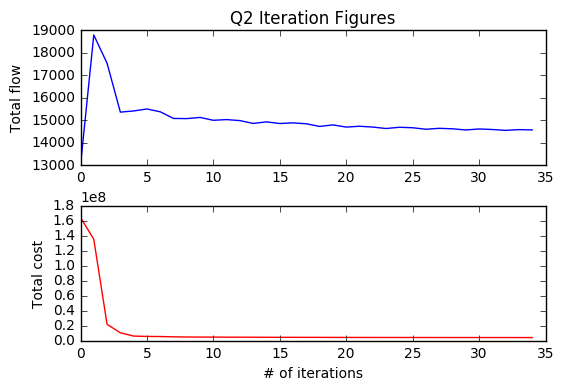

In [16]:
q2_iters = (q2.shape[1] - 5) // 2
q2_iterlst = list(map(lambda x: "xa{}".format(x), np.arange(q2_iters)))
q2_costlst = q2[q2_iterlst].apply(bpr, fft=q2.fftime, ca=q2.cap)

q2_xa_total = q2[q2_iterlst].apply(sum)
q2_cost_total = np.multiply(q2[q2_iterlst], q2_costlst).apply(sum)

# Plotting
plt.close("all")
fig, axarr = plt.subplots(2, sharex=True, sharey=False)
axarr[0].plot(np.arange(q2_iters), q2_xa_total, "b-")
#plt.hold(True)
axarr[0].set_ylabel("Total flow")
axarr[0].set_title("Q2 Iteration Figures")

axarr[1].plot(np.arange(q2_iters), q2_cost_total, "r-")
axarr[1].set_ylabel("Total cost")
axarr[1].set_xlabel("# of iterations")

# Show
fig.subplots_adjust(hspace=0.3)
fig.savefig(r'{}/pics/FrankWolfe-q2.png'.format(os.getcwd()), transparent=True, format="png")
plt.show()

## Q1 vs Q2

Compare UE and SO results:

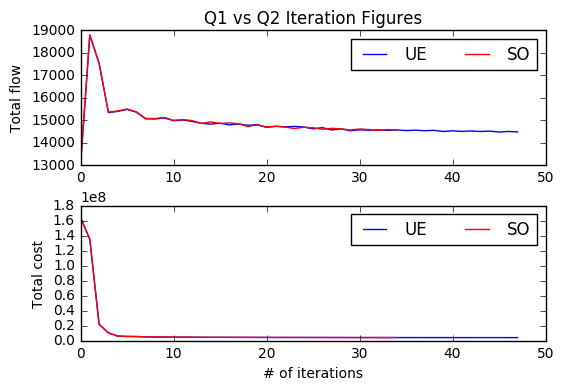

In [17]:
# Plotting
plt.close("all")
fig, axarr = plt.subplots(2, sharex=True, sharey=False)
axarr[0].plot(np.arange(q1_iters), q1_xa_total, "b-", label="UE")
axarr[0].hold(True)
axarr[0].plot(np.arange(q2_iters), q2_xa_total, "r-", label="SO")
axarr[0].set_ylabel("Total flow")
axarr[0].set_title("Q1 vs Q2 Iteration Figures")
axarr[0].legend(loc="upper right", ncol=2)

axarr[1].plot(np.arange(q1_iters), q1_cost_total, "b-", label="UE")
axarr[1].hold(True)
axarr[1].plot(np.arange(q2_iters), q2_cost_total, "r-", label="SO")
axarr[1].set_ylabel("Total cost")
axarr[1].set_xlabel("# of iterations")
axarr[1].legend(loc="upper right", ncol=2)

# Show
fig.subplots_adjust(hspace=0.3)
fig.savefig(r'{}/pics/FrankWolfe-q1-vs-q2.png'.format(os.getcwd()), transparent=True, format="png")
plt.show()

Except Q1 (UE) takes more iterations than Q2 (SO) to reach the error threshold, there's nearly no difference between total flow and total cost of these two equilibrium.

If we view the last iteration of q1 and q2 matrices shown above, we can also find there's few differences between link flow of these two.

## Q3

Find a number of bottleneck links (tell me your criteria of judging bottleneck links) in your network based on results from part 1, expand their capacities by a suitable amount, say 50%, and redo parts 1 & 2 (no need for plot the convergence curves). Comment on your results.

-----

## Q4 

Multiply the O-D demand for each O-D pair in the table by 0.25, 0.5, 0.75, 1.25, 1.5, 2.0, 3.0, 5.0, and re-do parts 1 and 2 (no need to plot the convergence curves in this problem), and plot the total travel times in UE and SO against the multipliers in the same graph (i.e., the vertical axis would be total travel times under UE and SO, respectively, and the horizontal axis would be 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 2.0, 3.0, 5.0), and discuss your results.

-----

## Q5

Experiment with the Davidson’s link performance function for the UE problem under the base demand:

$$ t_a = t_a^0\left[1 + J\frac{x_a}{c_a - x_a}\right], J = 0.25 $$

Discuss how convergence of Frank-Wolfe is affected.

-----

## Q6

Apply the incremental assignment algorithm to the network with Davidson’s link performance function, discuss your results.

-----